### Step 0 : Init RoboFeeder Env
This cell sets up the environment for the RoboFeeder simulation by importing necessary modules and configuring the Python path.

In [ ]:
import os 
dir = os.getcwd()
if 'examples' in dir:
    os.chdir(os.getcwd().split('examples')[0])
else:
    print("please set the working directory to the root of the gym4ReaL repository")

# check if the current working directory is the root of the gym4ReaL repository
os.getcwd()


'/home/edge/Desktop/gym4ReaL'


### Step 1 : Import Required Modules
This cell imports the necessary modules and updates the system path to include the gym4ReaL repository. It also imports the robot simulator and matplotlib for visualization purposes.


In [4]:
import sys
sys.path.append(os.getcwd())  # <-- path to the *parent* of gym4real

from gym4real.envs.robofeeder.src import robot_simulator as s
import os
import matplotlib.pyplot as plt

### Step 2a : Test Simulator
import the simulator configuration file to pass the required parameters to run. 
Relevant parameters to adapt:

#### ObjectToPick
    NUMBER_OF_OBJECTS: 1           # (int) Number of objects to pick
    SHUFFLE_OBJECTS: True          # (bool) Shuffle object positions at reset
    OBJ_CORRECT_ORIENTATION: True  # (bool) Ensure objects have correct orientation

#### Simulator Setting
    IS_SIMULATION_REAL_TIME: False   # (bool) Run simulation in real time
    IS_SIMULATION_SHOWED: True       # (bool) Show simulation window
    IS_SIMULATION_RECORD: False      # (bool) Record simulation video
    RECORD_FOLDER : "." # (str) Folder to save recorded videos



In [ ]:
import shutil

# Copy the default configuration file to a new editable file
default_config_file = os.getcwd() + "/gym4real/envs/robofeeder/configuration.yaml"
config_file = os.getcwd() + "/examples/robofeeder/notebooks/configuration_editable.yaml"
shutil.copy(default_config_file, config_file)

### Step 2b : Test Simulator
import the simulator class to setup the mujoco environment

In [ ]:
# Now config_file points to the editable copy
simulator = s(config_file)
simulator.reset()

### Step 3 : Test Object Coordinates
This cell calculates the initial coordinates and rotation of the object to be picked or placed. It uses the simulator's data to determine the position and orientation of the object and adjusts the height relative to the base link. The coordinates and rotation are printed for verification.

In [5]:
from scipy.spatial.transform import Rotation
import numpy as np


def normalizeAngle(angle):
    if(angle>np.pi):angle -=np.pi
    elif(angle<0):angle += np.pi
    return angle

# Set the end effector destination as as the position of the object
# change object to pick if it is picked
picked = simulator.objPicked
for i in range(len(picked)):
    if(picked[i] == 1):
        simulator.data.site(1).xpos = simulator.data.site(i+2).xpos.copy()
        # Reset The height of the object respect the base link
        simulator.data.site(1).xpos[2] = simulator.data.site(i+2).xpos[2] - 0.11
        # Get z-rotation of the object
        rot = Rotation.from_quat(simulator.data.qpos[3:7*(i+1)].copy()).as_euler('xyz')
        rot = normalizeAngle(2.35+rot[0])
        print("Object to pick:", i+2)
        break
    else:
        simulator.data.site(1).xpos = simulator.data.site(i+1).xpos.copy()
        # Reset The height of the object respect the base link
        simulator.data.site(1).xpos[2] = simulator.data.site(i+1).xpos[2] - 0.11
        # Get z-rotation of the object
        rot = Rotation.from_quat(simulator.data.qpos[3:7*(1)].copy()).as_euler('xyz')
        rot = normalizeAngle(2.35+rot[0])
        print("Object to place:", i+1)
        break
coords = simulator.data.site(1).xpos.copy()
coords[2] = 0.09
print("Initial coordinates:", coords)

print("Initial rotation:", rot)
c = coords.copy()
r = rot.copy()

Object to place: 1
Initial coordinates: [-0.3490128   0.34062989  0.09      ]
Initial rotation: 0.7776630051051168


### Step 4 :  Plot Observation Result
This cell visualizes the result of the pick simulation by plotting the observation image returned by the simulator. It also prints whether the pick operation was successful.

Result of the Simulator: 1


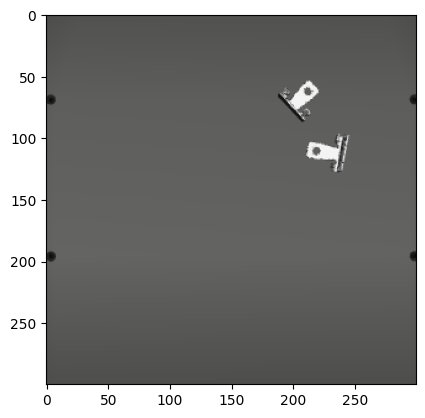

In [6]:
# Run the pick simulation
image, result = simulator.simulate_pick(coords,rot)

# Plot the image returned by the simulator
plt.imshow(image)

#1 if the pick was successful, 0 otherwise
print("Result of the Simulator:",result)


### Step 5 : Record Simulation Video
This cell checks if simulation recording is enabled in the simulator configuration. If enabled, it constructs the video path and displays the recorded simulation video in the notebook using an HTML video player.


In [6]:
import os
from IPython.display import HTML

if simulator.configs["IS_SIMULATION_RECORD"]:
    # Construct video path
    video_name = f"simulated_pick_{simulator.counter}.mp4"
    video_path = os.path.join(simulator.configs["RECORD_FOLDER"], video_name)
    
    display(HTML(f"""
    <div style="text-align: center;">
        <video width="300" height="300" controls>
            <source src="{video_path}" type="video/mp4">
            Your browser does not support the video tag.
        </video>
    </div>
    """))


### Step 6 : Reset The simulator
Reset the simulator if you would like to start again a pick and place cycle with a random position of the object, please re-run from Step : 3

In [7]:
#shuffle pieces
simulator.reset()